In [1]:
!pip install xgboost
import xgboost
import pandas as pd
import numpy as np
!pip install transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import get_scheduler

import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn import datasets

from xgboost import XGBClassifier
from xgboost import plot_importance

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import timedelta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
path = "/content/drive/My Drive/Colab Notebooks/capstone project"
import os
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
class SimpleProcessor():
    
    def __init__(self, priceFile, tweetsFile, tickerName, priceType):
        self.tickerName = tickerName
        self.priceType = priceType
        self.crypto_tweets = pd.read_csv(tweetsFile, index_col=0)
        self.price_vol = pd.read_csv(priceFile, index_col=0)
        self.crypto_price = self.price_vol[[tickerName + '-' + priceType]].shift(1)
        self.crypto_tweets.columns = [tickerName]
        self.crypto_price.index = pd.to_datetime(self.crypto_price.index).tz_convert(None)
        self.crypto_tweets.index = pd.to_datetime(self.crypto_tweets.index)
        self.data = None
        self.all_data = None
        
    def getData(self):
        data = self.crypto_tweets.merge(self.crypto_price, how = 'outer', left_index = True, right_index = True)
        data['returns'] = data[self.tickerName + '-' + self.priceType].pct_change().shift(-1)
        data['class'] = (data['returns'] > 0).astype(int)
        data = data.iloc[:-1, :]
        self.all_data = data
        
        nonewsdate = data[data.isna().any(axis=1)].index
        newsdate = data[~data.isna().any(axis=1)].index
        
        self.data = data[~data.isna().any(axis=1)][[self.tickerName, 'class']]
        self.data.columns = ['text', 'class']
        return self.data

In [5]:
coin = 'eth'

In [6]:
sp = SimpleProcessor('price_vol.csv', coin + '_all.csv', coin.upper(), 'close')
data = sp.getData()
data

,text,class
2020-09-26 01:00:00,monero price showing a little positive action ...,1
2020-09-26 02:00:00,If you dont pay attention to price impact do y...,1
2020-09-26 05:00:00,IM SO SUSPICIOUS OF THIS BULLISH PRICE ACTION ...,1
2020-09-26 07:00:00,Has anyone already tried ALGOV Looks interesti...,0
2020-09-26 13:00:00,Remember back in the days when a crypto exchan...,0
...,...,...
2022-09-24 19:00:00,Well I dont see the Bitcoin and the Crypto mar...,1
2022-09-24 20:00:00,Cardano price unmoved by Vasil upgrade despite...,0
2022-09-24 21:00:00,Bitcoin Cash prediction as price eyes breakout...,0
2022-09-24 22:00:00,Do you guys know the reason crypto never exper...,0


In [7]:
sp.all_data

,ETH,ETH-close,returns,class
2020-09-26 00:00:00,I am a twitter bot using AI to predict price m...,NaN,NaN,0
2020-09-26 01:00:00,monero price showing a little positive action ...,351.767883,0.002570,1
2020-09-26 02:00:00,If you dont pay attention to price impact do y...,352.671936,0.000179,1
2020-09-26 03:00:00,NaN,352.735046,-0.002808,0
2020-09-26 04:00:00,NaN,351.744507,0.002148,1
...,...,...,...,...
2022-09-24 23:00:00,Bottom is getting close cause Im wanting to ge...,1314.980591,0.002559,1
2022-09-25 00:00:00,NaN,1318.344971,0.001680,1
2022-09-25 01:00:00,NaN,1320.560181,0.000542,1
2022-09-25 02:00:00,NaN,1321.276123,-0.000359,0


In [8]:
class Embedding:
    
    def __init__(self, pre_trained='bert-base-uncased'):
        self.bert = BertModel.from_pretrained(pre_trained).to(device)
        self.bert.requires_grad_(False)
        self.tokenizer = BertTokenizer.from_pretrained(pre_trained)
        
    def forward(self, x):
        token = self.tokenizer(str(x), 
                               padding='max_length', 
                               truncation = True, 
                               max_length=100, 
                               return_tensors='pt').to(device)
        return self.bert(input_ids=token['input_ids'], 
                       attention_mask=token['attention_mask'])[1].detach().cpu().numpy()[0] 

In [9]:
# embedding = Embedding()
# res = []
# for i in trange(len(data)):
#     res.append(embedding.forward(data['text'][i]))

# df = pd.DataFrame([], index=data.index, columns=['sentence_embedding'])
# df['sentence_embedding'] = res
# df['sentence_embedding'] = df['sentence_embedding'].apply(lambda x: x.reshape(-1))
# df = df.merge(data['class'], left_index=True, right_index=True)
# df = pd.merge(df['sentence_embedding'].apply(pd.Series), df['class'], left_index=True, right_index=True)

# df.to_csv(coin + '_embedding_refined.csv')
df = pd.read_csv(coin + '_embedding_refined.csv', index_col=0)
df

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,class
2020-09-26 19:00:00,-0.754063,-0.477416,-0.917577,0.671671,0.655861,-0.127361,0.488707,0.264824,-0.646093,-0.999947,...,-0.155078,0.932360,0.723484,0.274041,0.127599,0.667183,-0.780633,-0.618963,0.680646,1
2020-09-28 07:00:00,-0.792884,-0.416185,-0.650477,0.645606,0.097019,-0.133725,0.797860,0.324588,-0.435389,-0.999903,...,0.351181,0.676000,0.789177,-0.425233,0.038325,0.650971,-0.383587,-0.592329,0.820076,0
2020-09-30 15:00:00,-0.778031,-0.724143,-0.998744,0.933427,0.976626,-0.494237,0.757799,0.439984,-0.993639,-0.999859,...,-0.827445,0.999300,0.637576,-0.795604,-0.744865,0.805962,-0.995084,-0.691034,0.768092,1
2020-10-01 16:00:00,-0.498644,-0.472059,-0.977640,0.604449,0.878424,-0.229053,0.263886,0.245750,-0.876719,-0.999503,...,-0.268910,0.990353,0.477164,0.185582,-0.231260,0.506453,-0.931142,-0.610913,0.568024,0
2020-10-06 13:00:00,-0.482437,-0.099311,-0.541113,0.247003,0.502054,0.054959,-0.138537,-0.115654,-0.108153,-0.999238,...,0.035711,0.695475,0.438013,0.120141,0.465985,0.538112,-0.660730,-0.334819,0.276645,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-24 18:00:00,-0.615346,-0.431359,-0.925874,0.603282,0.502589,-0.061985,0.375478,0.196896,-0.747548,-0.999808,...,-0.471982,0.962300,0.642093,-0.168555,0.070367,0.620677,-0.737904,-0.590337,0.704022,1
2022-09-24 19:00:00,-0.338000,-0.494484,-0.986247,0.447786,0.768355,-0.091249,0.039461,0.193332,-0.927064,-0.999509,...,-0.522661,0.982895,0.080323,-0.450290,-0.641686,0.740547,-0.956065,-0.538061,0.376463,1
2022-09-24 20:00:00,-0.709530,-0.476177,-0.891684,0.606465,0.530020,-0.132213,0.600406,0.345114,-0.772745,-0.999892,...,-0.084306,0.967545,0.645009,-0.470716,-0.071236,0.773765,-0.723627,-0.486756,0.758164,0
2022-09-24 21:00:00,-0.785479,-0.403738,-0.735485,0.627096,0.338608,-0.132200,0.666478,0.282433,-0.581752,-0.999903,...,0.056184,0.928906,0.776056,0.746504,0.452951,0.593001,-0.348611,-0.631340,0.895010,0


In [10]:
n = len(df)
percent = 0.8
training, test = df.iloc[0 : int(n * percent)], df.iloc[int(n * percent):]
training, validation = training.iloc[0 : int(n * percent)], training.iloc[int(n * percent):]
X_train, y_train = training.iloc[:, :-1], training.iloc[:, -1]
X_valid, y_valid = validation.iloc[:, :-1], validation.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

In [11]:
model = XGBClassifier(learning_rate=0.01,
                      n_estimators=10,           # how many trees
                      max_depth=4,               # maximum depth of the trees
                      min_child_weight = 1,      
                      gamma=0.,                  # penalty term for numbers of leafs
                      subsample=1,               # all samples
                      colsample_btree=1,         # all features
                      scale_pos_weight=1,        # solve unbalanced samples
                      random_state=27,           
                      slient = 0
                      )
model.fit(X_train, y_train)

XGBClassifier(colsample_btree=1, gamma=0.0, learning_rate=0.01, max_depth=4,
              n_estimators=10, random_state=27, slient=0)

In [12]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
y_test, y_pred = y_test, model.predict(X_test)
print("Accuracy : %.4g" % accuracy_score(y_test, y_pred))
print("Precision : %.4g" % precision_score(y_test, y_pred))
print("Recall : %.4g" % recall_score(y_test, y_pred))
y_train_proba = model.predict_proba(X_train)[:,1]
print("AUC Score (Train): %f" % roc_auc_score(y_train, y_train_proba))
y_proba = model.predict_proba(X_test)[:,1]
print("AUC Score (Test): %f" % roc_auc_score(y_test, y_proba))

Accuracy : 0.4956
Precision : 0.4933
Recall : 0.7702
AUC Score (Train): 0.608246
AUC Score (Test): 0.491477


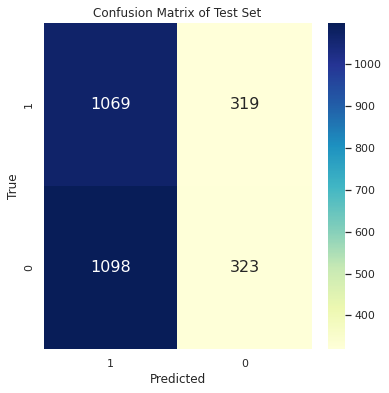

In [13]:
cm_test = confusion_matrix(y_test, y_pred, labels = [1, 0])
plt.figure(figsize = (6,6))
s = sns.heatmap(cm_test, annot= True, fmt = 'd', annot_kws={'size': 16}, 
                cmap ='YlGnBu', xticklabels=[1, 0], yticklabels=[1, 0])
_ = s.set_xlabel('Predicted')
_ = s.set_ylabel('True')
_ = s.set_title('Confusion Matrix of Test Set')

In [14]:
bt_data = pd.DataFrame([], index=pd.to_datetime(test.index))
bt_data['y_pred'] = y_pred
bt_data = sp.all_data.loc[test.index[0]:, ['returns', 'class']].merge(bt_data, left_index=True, right_index=True)
bt_data = bt_data.ffill().dropna()
bt_data['strat_ret'] = bt_data['returns'] * bt_data['y_pred']
bt_data['nav'] = np.cumprod(1 + bt_data['returns'])
bt_data['strat_nav'] = np.cumprod(1 + bt_data['strat_ret'])
bt_data

                     y_pred
2022-05-02 22:00:00       1
2022-05-02 23:00:00       1
2022-05-03 00:00:00       1
2022-05-03 01:00:00       1
2022-05-03 02:00:00       0
...                     ...
2022-09-24 18:00:00       1
2022-09-24 19:00:00       0
2022-09-24 20:00:00       1
2022-09-24 21:00:00       0
2022-09-24 22:00:00       1

[2809 rows x 1 columns]


,returns,class,y_pred,strat_ret,nav,strat_nav
2022-05-02 22:00:00,-0.001070,0,1,-0.001070,0.998930,0.998930
2022-05-02 23:00:00,-0.001563,0,1,-0.001563,0.997369,0.997369
2022-05-03 00:00:00,-0.006046,0,1,-0.006046,0.991339,0.991339
2022-05-03 01:00:00,0.001073,1,1,0.001073,0.992403,0.992403
2022-05-03 02:00:00,-0.000902,0,0,-0.000000,0.991508,0.992403
...,...,...,...,...,...,...
2022-09-24 18:00:00,0.004512,1,1,0.004512,0.513879,0.729875
2022-09-24 19:00:00,0.000431,1,0,0.000000,0.514101,0.729875
2022-09-24 20:00:00,-0.000574,0,1,-0.000574,0.513806,0.729456
2022-09-24 21:00:00,-0.013560,0,0,-0.000000,0.506839,0.729456


In [15]:
class backtest_metrics:
    
    def __init__(self, coin_name, df, col1, col2):
        self.name = coin_name
        self.nav = df[[col1, col2]]
        self.nav = pd.concat([pd.DataFrame([[1.0, 1.0]], index=[self.nav.index[0] - timedelta(hours=1)], columns=[col1, col2]), self.nav])
        self.ret = (df - df.shift(1))/df.shift(1)
        self.N = len(df) - 1
        self.metrics = pd.DataFrame([], columns=[col1, col2])
        
    def get_return(self):
        self.metrics.loc['annualized return'] = (np.power(self.nav.iloc[-1, :] / self.nav.iloc[0, :], 365*24 / self.N) - 1)
    
    def get_vol(self):
        self.metrics.loc['annualized std'] = (np.std(self.ret)*np.sqrt(365*24))
    
    def get_sharpe(self):
        self.metrics.loc['sharpe ratio'] = self.metrics.loc['annualized return'] / self.metrics.loc['annualized std']
    
    def get_cumReturn(self):
        self.metrics.loc['accumulated return'] = (self.nav.iloc[-1,:]/self.nav.iloc[0,:] - 1)
    
    def get_maxdd(self):
        self.metrics.loc['maximum drawdown'] = ((np.maximum.accumulate(self.nav) - self.nav) / np.maximum.accumulate(self.nav)).max()
        
    def get_metrics(self):
        self.get_return()
        self.get_vol()
        self.get_sharpe()
        self.get_cumReturn()
        self.get_maxdd()
        return self.metrics
    
    def nav_curve(self, output=False):
        plt.figure(figsize=(10, 5), dpi=300)
        plt.title(self.name)
        plt.plot(self.nav['nav'], label="nav")
        plt.plot(self.nav['strat_nav'], label='strat_nav')
        plt.legend(fontsize=10)

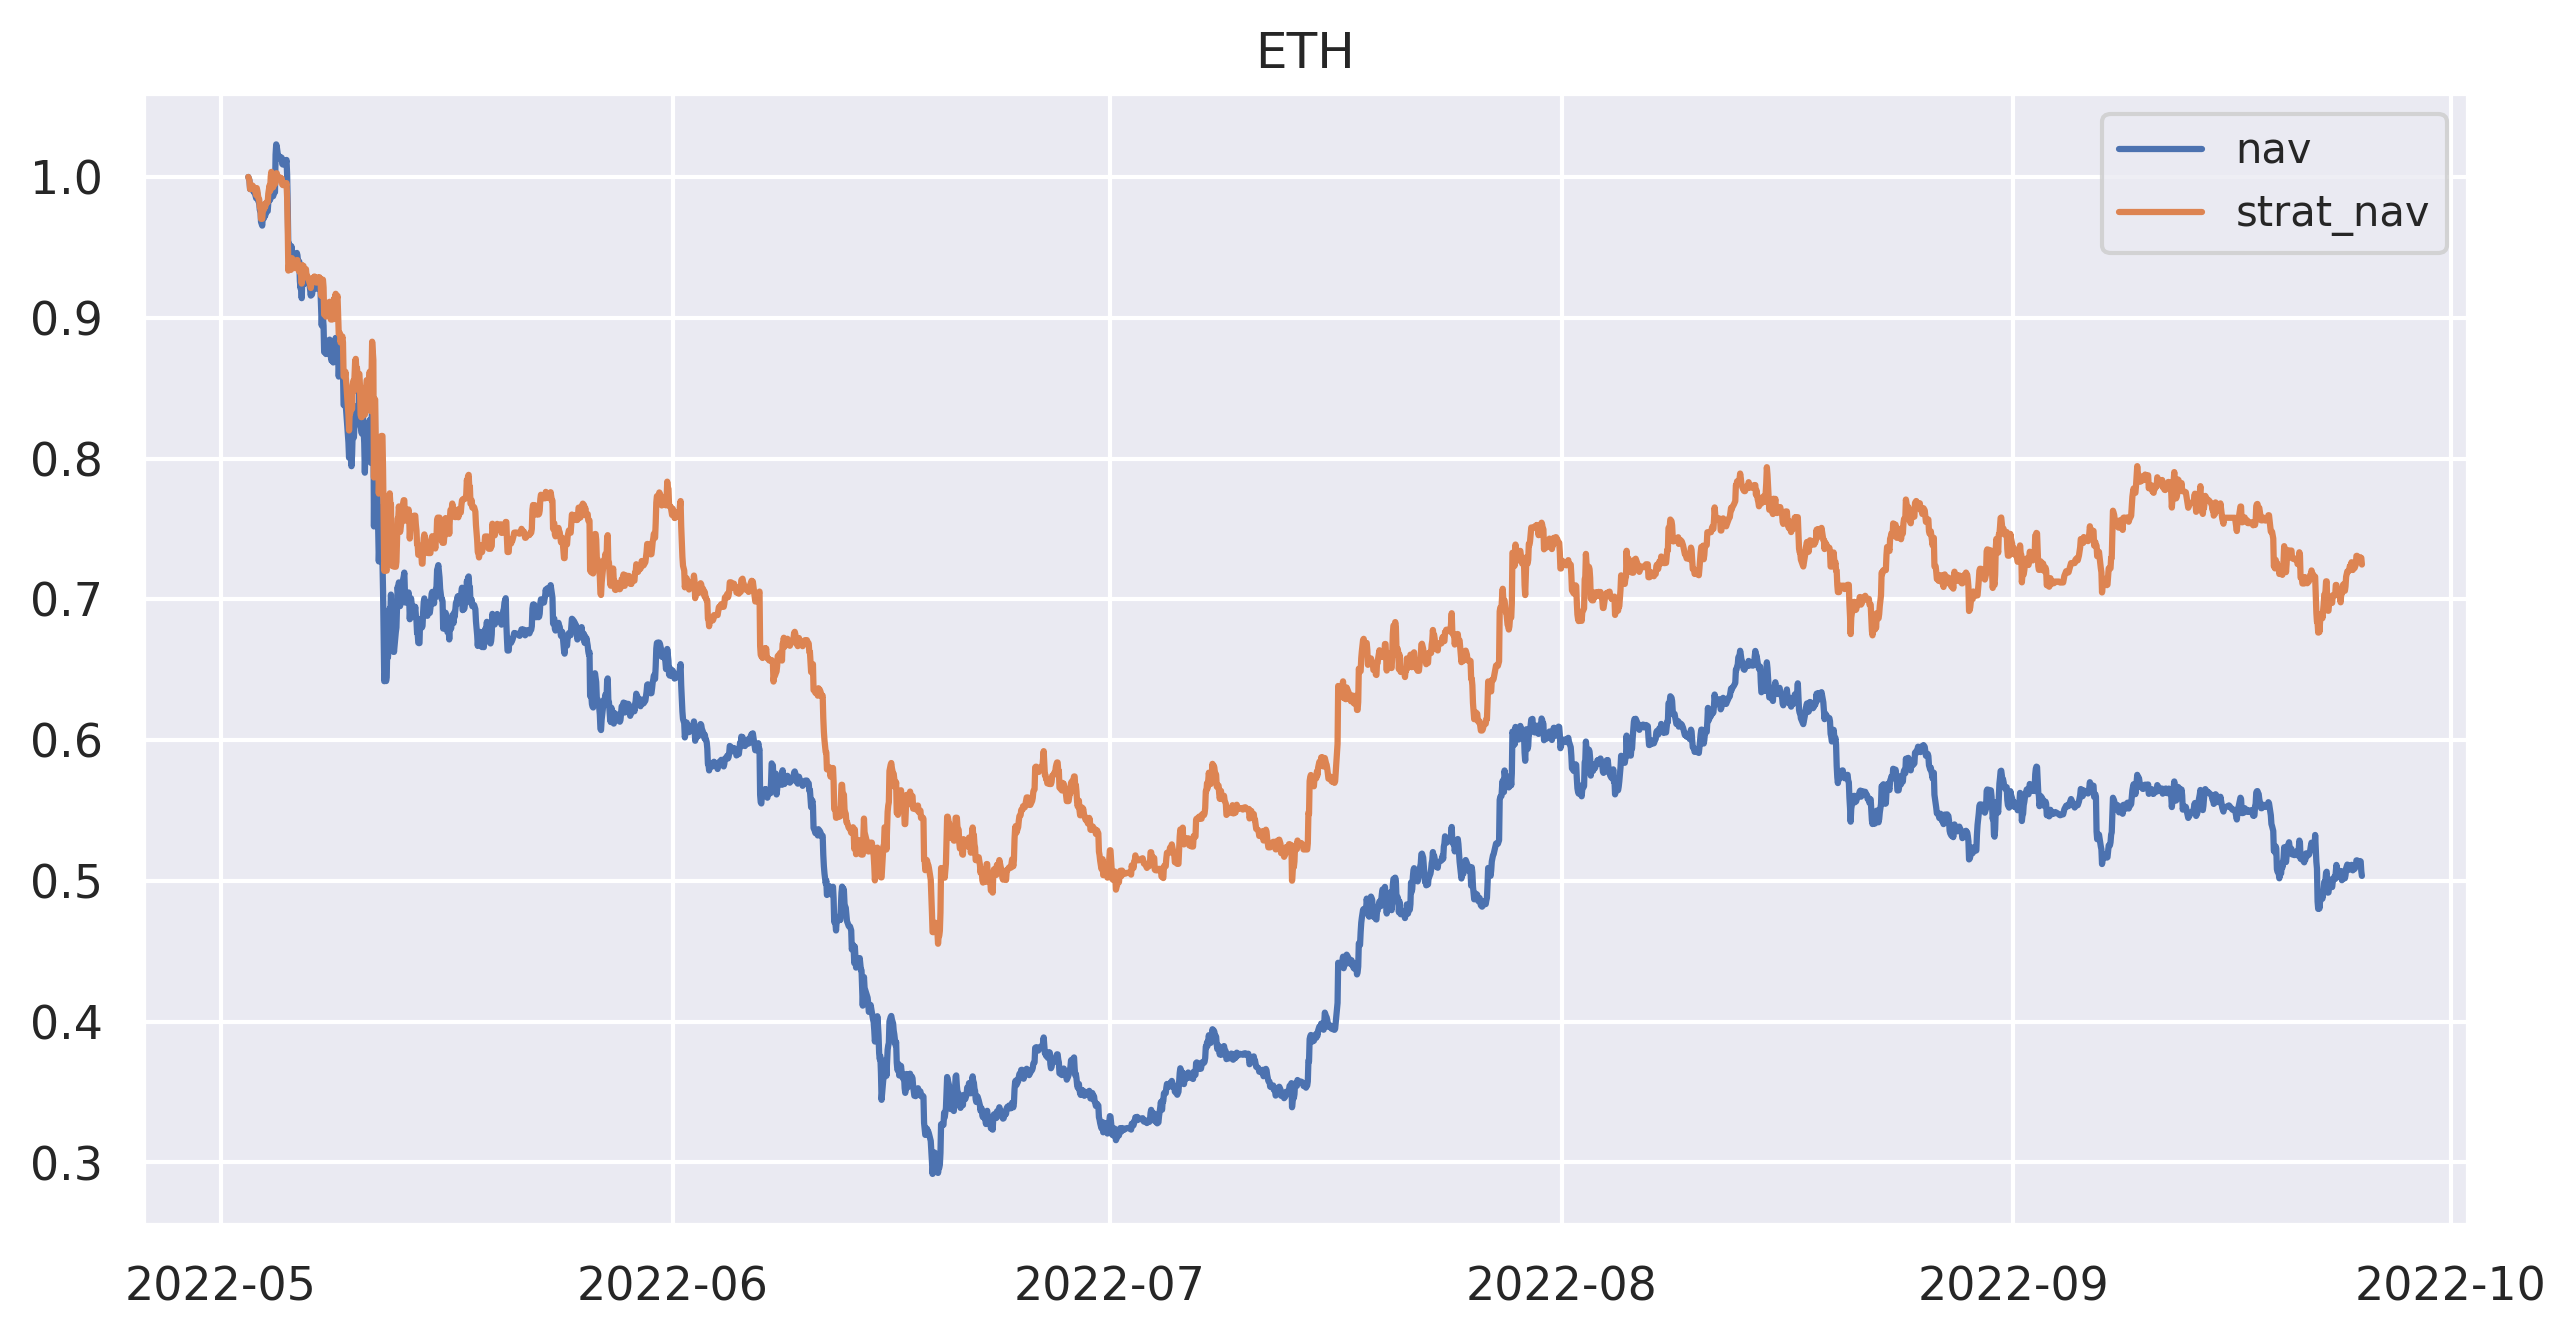

In [16]:
bt = backtest_metrics(coin.upper(), bt_data, 'nav', 'strat_nav')
bt.get_metrics()
bt.nav_curve()